**10.7 [Computational] MCMC.** Setting up a basic Markov chain Monte Carlo is quite straightforward, as you will now demonstrate. Use the same dataset as in Problem 10.5, with four measurements with uncorrelated error bars, and consider the same model as there,
$y = mx$ (model 1).

**a)** Set up the MCMC algorithm in the single parameter m and run it for some reasonably large number of steps (say, 10,000). [If you wish, you can look up the Gelman-Rubin convergence criterion and track it as well.]

**b)** Report the acceptance rate of your chain. If the value is either far too large or too small (relative to the optimal rate of ballpark 0.25), then change the stepsize accordingly, repeat the MCMC run, and see if the acceptance rate improves.


**c)** Plot the posterior in m. Find the best-fit value of this parameter, and its 68% credible interval.


**d)** Calculate the Bayesian evidence of your model,
$$P(D|model)=\int \mathcal{L}(D|m)P(m)dm$$
Note that you should use the properly normalized prior so that
$$\int P(m)dm = 1$$
Adopt the range $m \in [0, 5]$, and a uniform prior so that $P (m) = const. [Note, it might be easiest to not use your MCMC calculation, but rather calculate the evidence directly by summing on a grid in m. ]

**e)** Now consider a more complicated model:
$y = mx + b$ (model 2), with two free parameters, m and b. Calculate the Bayesian evidence of this model as well. You don’t need to run MCMC, just evaluate the evidence by summing on a grid of (m,b). Adopt the same m range as in part d), and the range $b=[-2, 2]$. And a uniform prior as before, normalized as $$\int P(m)dmdb = 1$$
Then evaluate the Bayes factor
$$B_{21} = \frac{P(D|model 2)}{P(D|model 1)} = \frac{\int \mathcal{L}(D|m)P(m)dmdb}{\int \mathcal{L}(D|m)P(m)dm}$$
where the numerator and the denominator are the Bayesian evidences for the two models respectively. With your result for $B_{21}$, use the Jeffreys scale (Table 10.1) to assess if the data prefer model 2 over model 1.

Dataset: 
$$y(x=1)= 2.0 \pm 1.0$$
$$y(x=2)= 4.0 \pm 2.0$$
$$y(x=3)= 6.0 \pm 3.0$$
$$y(x=4)= 8.0 \pm 4.0$$
Assume these four measurements are independent and identically distributed and that each comes from a Gaussian distribution.


Below is pseudocode for the Metropolis-Hastings MCMC algorithm in Figure 10.6 in Huterer:

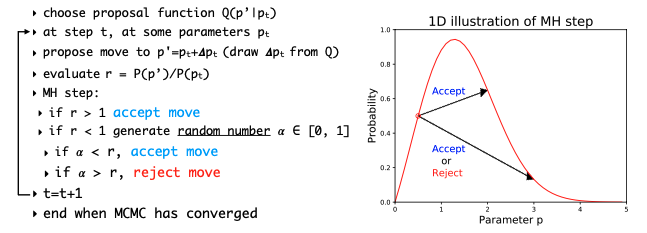

In [3]:
#import necessary packages
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from numpy import random
from scipy import stats as st
from scipy.integrate import quad, nquad
import statistics

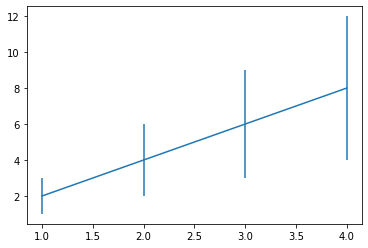

In [4]:
#dataset
xs = [1.0, 2.0, 3.0, 4.0]
ys = [2.0, 4.0, 6.0, 8.0] 
err=[1,2,3,4]
#make a plot that displays the error bars
plt.errorbar(xs, ys, err)
#create a np array that turns our data into (x, y) coordinate pairs
data=np.array(list(zip(xs, ys)), dtype=[('x',float),('y',float)])

x and y have a linear relationship, hence why we pick y=mx as our model

### Part A: ###

In [121]:
# using default sigma = x for variance (width of Gaussian dist) since problem does not specify
# modified likelihood to be general for b-parameter
# added sigma_factor parameter, modifies sigma value by multiplying x by a specified factor
def likelihood_not_normalized(m, data, b=0, sigma_factor=1):
    chi_squared_sum = 0
    for row in data:
        x = row['x']
        y_data = row['y']
        y_model = m * x + b
        chi_squared_sum+=(y_model - y_data)**2/(x*sigma_factor)**2
    #return chi_squared_sum
    likelihood = np.exp(-1*(chi_squared_sum)/2) 

    return likelihood
        
        

In [161]:
normalizing_factor_1_param = quad(lambda m: likelihood_not_normalized(m, data), 0, 5)[0]
print(normalizing_factor_1_param)
normalizing_factor_2_param = nquad(lambda m, b: likelihood_not_normalized(m, data, b), [[0, 5], [-2,2]])[0]
print(normalizing_factor_2_param)


1.2532744420638604
4.07102284582329


In [162]:
def likelihood(m, data, b=0, sigma_factor=1):
    chi_squared_sum = 0
    for row in data:
        x = row['x']
        y_data = row['y']
        y_model = m * x + b
        chi_squared_sum+=(y_model - y_data)**2/(x*sigma_factor)**2
    likelihood = np.exp(-1*(chi_squared_sum)/2)
    if b==0: # in 1-param model, use 1st normalizing factor
        return likelihood/normalizing_factor_1_param
    if b!=0: # in 2-param mode, use 2nd normalizing factor
        return likelihood/normalizing_factor_2_param

In [163]:
def MCMC_1_param(data, sigma_factor=1, scale=2.5):
    # initialization

    steps = 10000 #10,000 steps
    p_0 = random.uniform(low=0.0, high=5.0) #choose an initial value for p within the range for p
    states = [p_0] #add initial p to states
    accepted = 0
    print(states)
    #posterior_in_m = [p_0,likelihood(p_0, data)]
    posterior_m = [likelihood(p_0, data)]

    for t in range(steps):
    
        p_current = states[-1] #grab most recent value in states
        p_new = random.normal(loc=p_current, scale = scale) # generate a candidate p' for the next sample
        likelihood_p_new = likelihood(p_new, data)
        likelihood_p_current = likelihood(p_current, data)
        r = likelihood_p_new/likelihood(p_current, data) # uniform prior, therefore post/post = lik/lik
    
        if r >= 1: 
            states.append(p_new)
            posterior_m.append(likelihood_p_new)
            accepted += 1
        elif r < 1:
            alpha = random.rand()
            if r > alpha:
                states.append(p_new)
                posterior_m.append(likelihood_p_new)
                accepted += 1
            else: 
                states.append(p_current)
                posterior_m.append(likelihood_p_current)
    
    # Burn in - I omit the first 1000 states to remove dependence on initial conditions    
    states = states[1000:]
    posterior_m = posterior_m[1000:]
    return states, posterior_m, accepted/steps
    

In [164]:
states, posterior_m, acceptance_rate = MCMC_1_param(data, sigma_factor=1, scale=2.5)

[4.426016659479547]


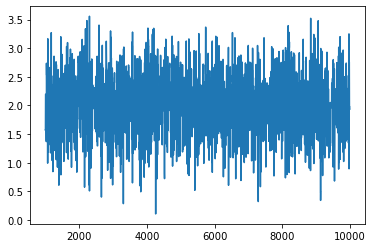

In [165]:
plt.plot(np.arange(1000, 10001), states)


(0.0, 5.0)

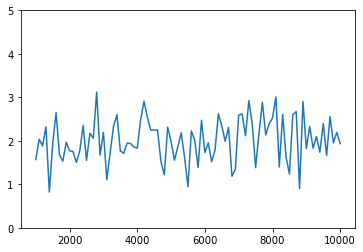

In [166]:
#plot only every 100th state (better visualization)
plt.plot(np.arange(1000, 10001)[::100], states[::100])
plt.ylim(0,5)

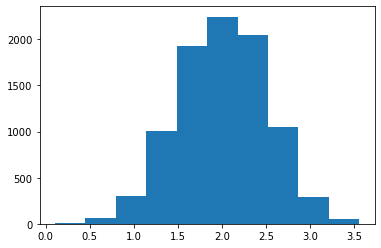

In [167]:
freq, bins, _ = plt.hist(states)

In [168]:
# print MCMC predicted value of m (peak of the histogram)
m_MCMC = bins[np.where(freq == freq.max())][0]
print(m_MCMC)

1.8316588255876225


### Part B: ###

In [170]:
# print acceptance rate
print(f'Acceptance rate: {acceptance_rate}')

Acceptance rate: 0.2414


### Part C: ###

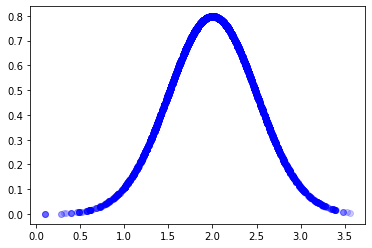

In [171]:
# Plot the posterior in m. Find the best-fit value of this parameter, and its 68% credible interval.

# plot posterior(p_new) vs p_new here

plt.plot(states, posterior_m, 'bo', alpha=0.2) 

In [172]:
def stats_1param(ps):
    med = np.median(ps)
    stdev = statistics.stdev(ps)
    conf_int = st.norm.interval(0.68, loc=np.mean(ps), scale=statistics.stdev(ps)) # 68% interval
    print(f'median: {med}, stdev: {stdev}, 68% conf int: {conf_int}')
    return med, stdev, conf_int    

In [173]:
median, stdev, conf_int = stats_1param(states)

median: 2.0022072546994467, stdev: 0.5036650095577988, 68% conf int: (1.5029933858078024, 2.50474066431114)


### Part D: ###

In [174]:
def bayesian_evidence(data): 
    integrand = lambda m: likelihood(m, data)*1/(5-0) # likelihood times normalized prior
    integral = quad(integrand, 0, 5) # uniform prior so prior const
    return(integral[0])
    

In [175]:
bayesian_evidence_model1 = bayesian_evidence(data)
bayesian_evidence_model1

0.19999999999999996

### Part E: ###

In [197]:
def bayesian_evidence_2param(data, b1, b2): 
    integrand = lambda m,b: likelihood(m, data, b)*1/(5-0) *1/(b2-b1)
    integral = nquad(integrand, [[0, 5], [b1,b2]])
    return (integral[0])
    

In [198]:
bayesian_evidence_model2 = bayesian_evidence_2param(data, -2, 2)
bayesian_evidence_model2

0.05

In [199]:
bayes_factor_21 = bayesian_evidence_model2/bayesian_evidence_model1
bayes_factor_21

0.25000000000000006

In [200]:
np.absolute(np.log(bayes_factor_21))

1.3862943611198904

Jeffrey's Scale - the following values for |ln B_21| indicate a strength of evidence for one model 2 over model 1 as follows:

<1.0: Inconclusive

1.0-2.5: Weak evidence

2.5-5.0: Moderate evidence

5.0: Strong evidence

A value of 1.38 indicates weak evidence for the strength of model 2 over model 1


### BONUS: ### 
Below I plot the 2D posterior for parameters m and b

In [181]:
X = np.linspace(0, 5, 50)
Y = np.linspace(-2, 2, 50)
ms, bs = np.meshgrid(X, Y)

In [182]:
 # likelihood is not normalized, posterior is proportional to likelihood due to uniform prior
posteriors = np.zeros((50,50))

for i in range(50):
    for j in range(50):
        posteriors[i,j] = likelihood(ms[i,j], data, b=bs[i,j]) # posterior equal to likelihood since uniform prior

Text(0, 0.5, 'Parameter 2: b')

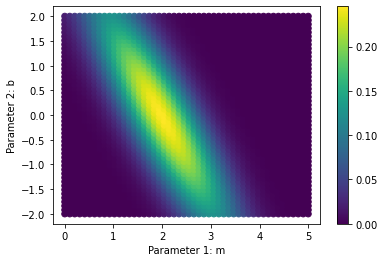

In [183]:
plt.scatter(ms, bs, c=posteriors)
plt.colorbar()
plt.xlabel("Parameter 1: m")
plt.ylabel("Parameter 2: b")

### BONUS: ###
Reduce error bars by factor of 10, shuffle y data points by some small amount, run MCMC again

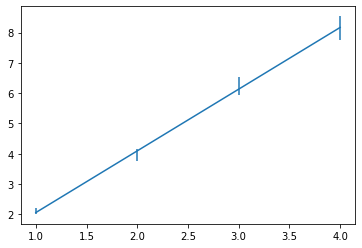

In [184]:
#generate dataset
xs = [1.0, 2.0, 3.0, 4.0]
ys_original = [2.0, 4.0, 6.0, 8.0]
ys = [y + np.random.normal(scale=0.2) for y in ys_original] # here I shift each original y-value by a random small amount

err=[0.1,0.2,0.3,0.4] # error bars have been reduced by a factor of 10

a, b = np.polyfit(xs, ys, 1) # best fit line just to see how points line up

plt.errorbar(xs, ys, err, 0, 'none')
plt.plot(xs, a*np.array(xs)+b)
data_shuffled=np.array(list(zip(xs, ys)), dtype=[('x',float),('y',float)])

In [185]:
print(likelihood(2.5, data_shuffled, sigma_factor=0.1))
print(likelihood(2, data_shuffled, sigma_factor=0.1))

1.492785370920944e-18
0.2771952467891158


In [186]:
states_sh, posterior_m_sh, acceptance_rate_sh = MCMC_1_param(data_shuffled, sigma_factor=0.1)

[4.402819460547946]


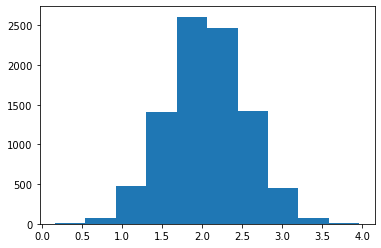

In [187]:
freq, bins, _ = plt.hist(states_sh)

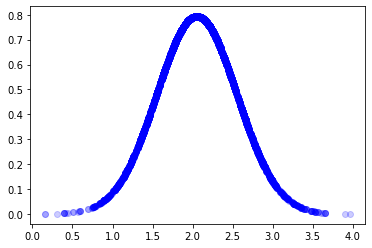

In [188]:
plt.plot(states_sh, posterior_m_sh, 'bo', alpha=0.2) 

In [189]:
median_sh, stdev_sh, conf_int_sh = stats_1param(states_sh)

median: 2.0553089803270606, stdev: 0.48937568475215903, 68% conf int: (1.5683008698853442, 2.5416278849912555)


### BONUS: ###
Run MCMC for 2 parameters, m and b

In [190]:
def MCMC_2_params(data, sigma_factor=1, scale=2.5):
    # initialization

    steps = 10000 #10,000 steps
    m_0 = random.uniform(low=0.0, high=5.0) #choose an initial value for m within the range for m
    b_0 = random.uniform(low=-2.0, high=2.0)
    states = [[m_0, b_0]] #add initial parameters to states
    accepted = 0
    print(states)

    posterior = [likelihood(m_0, data, b=b_0, sigma_factor=sigma_factor)]

    for t in range(steps):
    
        m_current = states[-1][0] #grab most recent m value in states
        b_current = states[-1][1] # grab most recent b value in states
        m_new = random.normal(loc=m_current, scale = scale) # generate a candidate m' for the next sample
        b_new = random.normal(loc=b_current, scale = scale) # generate a candidate b' for the next sample
        likelihood_new = likelihood(m_new, data, b=b_new, sigma_factor=sigma_factor)
        likelihood_current = likelihood(m_current, data, b=b_current, sigma_factor=sigma_factor)
        r = likelihood_new/likelihood_current # uniform prior, therefore post/post = lik/lik
    
        if r >= 1: 
            states.append([m_new, b_new])
            posterior.append(likelihood_new)
            accepted += 1
        elif r < 1:
            alpha = random.rand()
            if r > alpha:
                states.append([m_new, b_new])
                posterior.append(likelihood_new)
                accepted += 1
            else: 
                states.append([m_current, b_current])
                posterior.append(likelihood_current)
    
    # Burn in - I omit the first 1000 states to remove dependence on initial conditions    
    states = states[1000:]
    posterior = posterior[1000:]
    return states, posterior, accepted/steps

In [191]:
states_2p, posterior_2p, acceptance_rate_2p = MCMC_2_params(data, scale=1.75)

[[1.7171586629707276, 1.669129675005526]]


In [192]:
# print acceptance rate
print(f'Acceptance rate: {acceptance_rate_2p}')

Acceptance rate: 0.2525


Text(0, 0.5, 'Parameter 2: b')

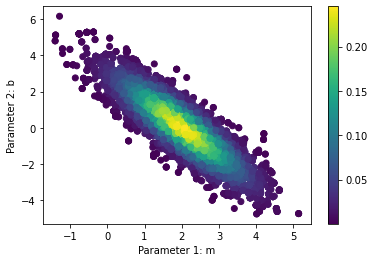

In [193]:
ms = [m for m,b in states_2p]
bs = [b for m,b in states_2p]
plt.scatter(ms, bs, c=posterior_2p)
plt.colorbar()
plt.xlabel("Parameter 1: m")
plt.ylabel("Parameter 2: b")

In [194]:
med_m, stdev_m, conf_int_m = stats_1param(ms)

median: 1.8912441353823677, stdev: 1.021594798959028, 68% conf int: (0.9131964027358555, 2.945062405277632)


In [195]:
med_b, stdev_b, conf_int_b = stats_1param(bs)

median: 0.11297979193104624, stdev: 1.713956693807191, 68% conf int: (-1.618588626108366, 1.7903268651650068)


# Bonus: ###
2D stuff with shuffled data

Text(0, 0.5, 'Parameter 2: b')

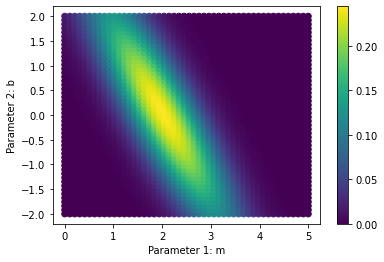

In [196]:
X = np.linspace(0, 5, 50)
Y = np.linspace(-2, 2, 50)
ms, bs = np.meshgrid(X, Y)

 # likelihood is not normalized, posterior is proportional to likelihood due to uniform prior
posteriors = np.zeros((50,50))

for i in range(50):
    for j in range(50):
        posteriors[i,j] = likelihood(ms[i,j], data_shuffled, b=bs[i,j]) # posterior equal to likelihood since uniform prior

plt.scatter(ms, bs, c=posteriors)
plt.colorbar()
plt.xlabel("Parameter 1: m")
plt.ylabel("Parameter 2: b")
